In [71]:
%matplotlib inline
from __future__ import print_function, unicode_literals
import sys, os
import json
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
from shapely.geometry import box

In [21]:
from pygaarst import raster
sys.path.append("../firedetection/")
import viirsswathtools as vst

In [8]:
ALT1 = True
ALT2 = False 
basedir = '/Volumes/cwdata1/VIIRS/GINA/dds.gina.alaska.edu/NPP/viirs/'
outdir = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/rasterout/'
if ALT1:
    basedir = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/'
elif ALT2:
    basedir = '/Volumes/SCIENCE/Fire/DATA_BY_AREA/2015/VIIRS/'

if os.path.isdir(basedir):
    print(basedir, "exists")
else:
    print("Please check directory {}: cannot access it.".format(basedir))

/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/ exists


In [121]:
sns.set(rc={'image.cmap': 'magma'})
sns.set_context("poster", font_scale=1.4)
earth='cornsilk'
water='lightskyblue'
cmap4_9 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'lime green']))
cmap4_193 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'teal']))
cmap5_65 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'bright blue']))

In [16]:
granulecatalogfn = 'viirsgranulecatalog_in_ROI.json'
with open(os.path.join(basedir, granulecatalogfn), 'rU') as src:
    granuledir = json.load(src)
granuleDF = pd.DataFrame.from_dict(granuledir, orient='index')
testgranule = granuleDF.loc[u'20150706_2136198']

In [94]:
testscene04 = raster.VIIRSHDF5(os.path.join(testgranule['dir'], testgranule['SVI04']))
testscene05 = raster.VIIRSHDF5(os.path.join(testgranule['dir'], testgranule['SVI05']))
pixelq4 = testscene04.pixelquality
pixelq5 = testscene05.pixelquality

## Plot of location with anomalies on map

In [53]:
sample_lat, sample_lon = 66.0, -154.75
imin, imax, jmin, jmax = testscene04.crop(sample_lat, sample_lon, 100, 100)

In [54]:
skips = vst.get_skips(testscene04, imin, imax, jmin, jmax)
skiprows = vst.get_badrows(skips)

In [91]:
skiprows

array([ 16,  17,  18,  19,  20,  21,  48,  49,  50,  51,  52,  53,  80,
        81,  82,  83,  84,  85, 112, 113, 114, 115, 116, 117, 144, 145,
       146, 147, 148, 149, 176, 177, 178, 179, 180, 181])

In [125]:
scene = testscene04
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]
testdat = testdat*mult + add
plotraster4 = np.delete(testdat, skiprows, 0)

In [126]:
scene = testscene05
bandname = scene.bandname
testdat = scene.dataobj['All_Data'][bandname]['BrightnessTemperature'][imin:imax, jmin:jmax]
mult, add = scene.dataobj['All_Data'][bandname]['BrightnessTemperatureFactors'][:]
testdat = testdat*mult + add
plotraster5 = np.delete(testdat, skiprows, 0)

In [103]:
pixq4 = pixelq4[imin:imax, jmin:jmax]
pixq4 = np.delete(pixq4, skiprows, 0)
pixq5 = pixelq5[imin:imax, jmin:jmax]
pixq5 = np.delete(pixq5, skiprows, 0)

In [104]:
q4cond_9 = (pixq4 == 9)
q4cond_193 = (pixq4 == 193)
q5cond_65 = (pixq5 == 65)
q4_9_masked = np.ma.masked_where(~q4cond_9, np.ones(plotraster.shape))
q4_193_masked = np.ma.masked_where(~q4cond_193, np.ones(plotraster.shape))
q5_65_masked = np.ma.masked_where(~q5cond_65, np.ones(plotraster.shape))

In [105]:
lons = np.delete(scene.lons[imin:imax, jmin:jmax], skiprows, 0)
lats = np.delete(scene.lats[imin:imax, jmin:jmax], skiprows, 0)

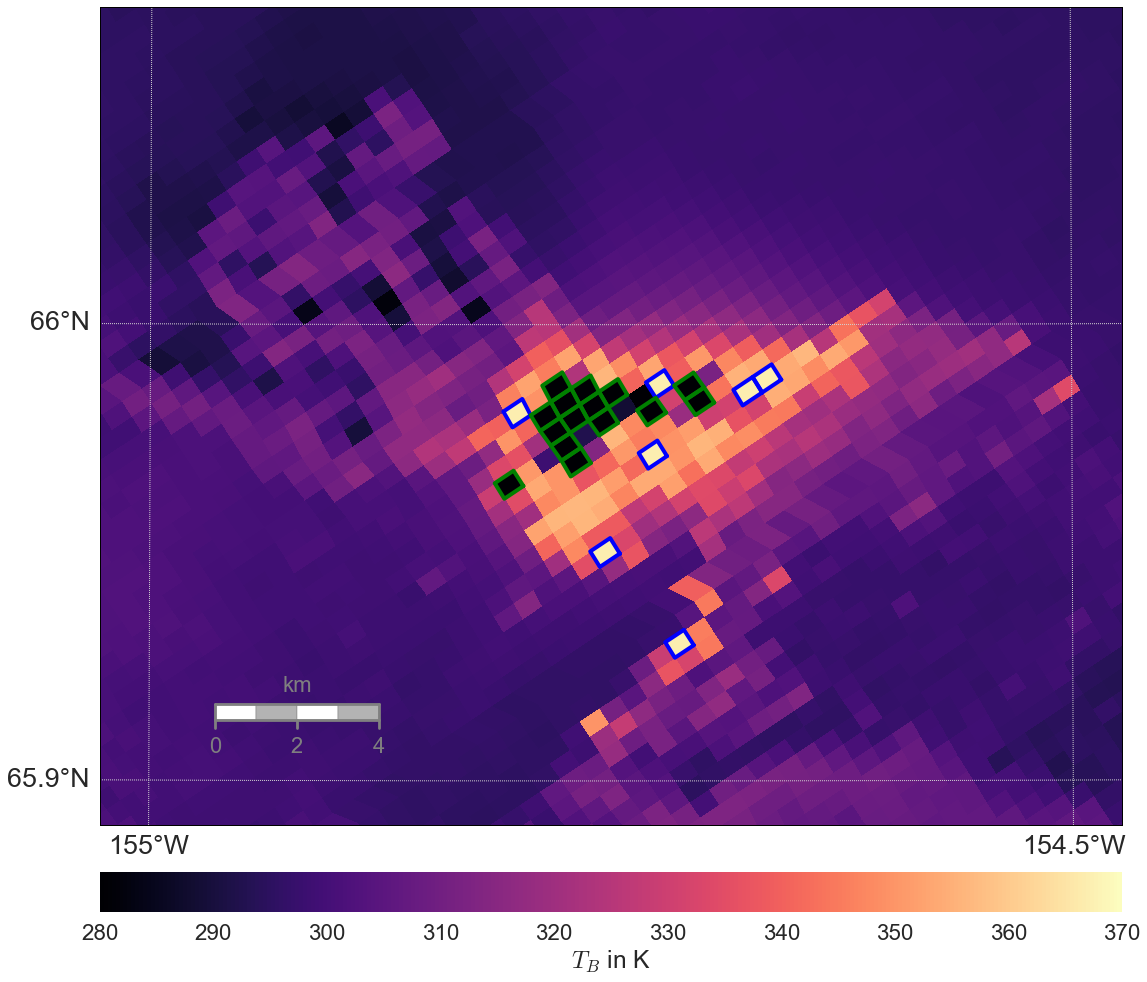

In [124]:
fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
mm = Basemap(
    width=25000, height=20000, 
    resolution='i', 
    projection='aea', 
    lat_1=60., lat_2=70., lat_0=65.98, lon_0=sample_lon)
mm.drawrivers(color=water, linewidth=1.5);
mm.drawmeridians(
    np.arange(-180, 180, .5), 
    color='lightgrey',
    linewidth=1,
    labels=[False, False, False, True]);
mm.drawparallels(
    np.arange(0, 80, .1), 
    linewidth=1,
    color='lightgrey',
    labels=[True, False, False, False]);
mm.fillcontinents(        
    color=earth,
    lake_color=water)
mm.drawmapboundary(fill_color=water);
xx, yy = mm(lons, lats)
dataplt = mm.pcolormesh(xx, yy, plotraster4, edgecolors='None', vmin=280, vmax=370, zorder=2)

iis, jjs =  np.where(pixq4 == 9)
for ii, jj in zip(iis, jjs):
    boxlons = [lons[ii, jj], lons[ii, jj+1], lons[ii+1, jj+1], lons[ii+1, jj], lons[ii, jj]]
    boxlats = [lats[ii, jj], lats[ii, jj+1], lats[ii+1, jj+1], lats[ii+1, jj], lats[ii, jj]]
    x, y = mm(boxlons, boxlats)
    ax1.plot(x, y, color='blue', linewidth=4, zorder=5)
iis, jjs =  np.where(pixq4 == 193)
for ii, jj in zip(iis, jjs):
    boxlons = [lons[ii, jj], lons[ii, jj+1], lons[ii+1, jj+1], lons[ii+1, jj], lons[ii, jj]]
    boxlats = [lats[ii, jj], lats[ii, jj+1], lats[ii+1, jj+1], lats[ii+1, jj], lats[ii, jj]]
    x, y = mm(boxlons, boxlats)
    ax1.plot(x, y, color='green', linewidth=4, zorder=5)
mm.drawmapscale(-154.92, 65.915, -154.7, 66.1, 4, 
                    barstyle="fancy", fontsize=22, zorder=6,
                    fontcolor='0.5', fillcolor2='0.7');

plt.tight_layout()
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size='5%', pad=0.65)
cbar = plt.colorbar(dataplt, orientation='horizontal', cax=cax)
cbar.set_label("$T_B$ in K")


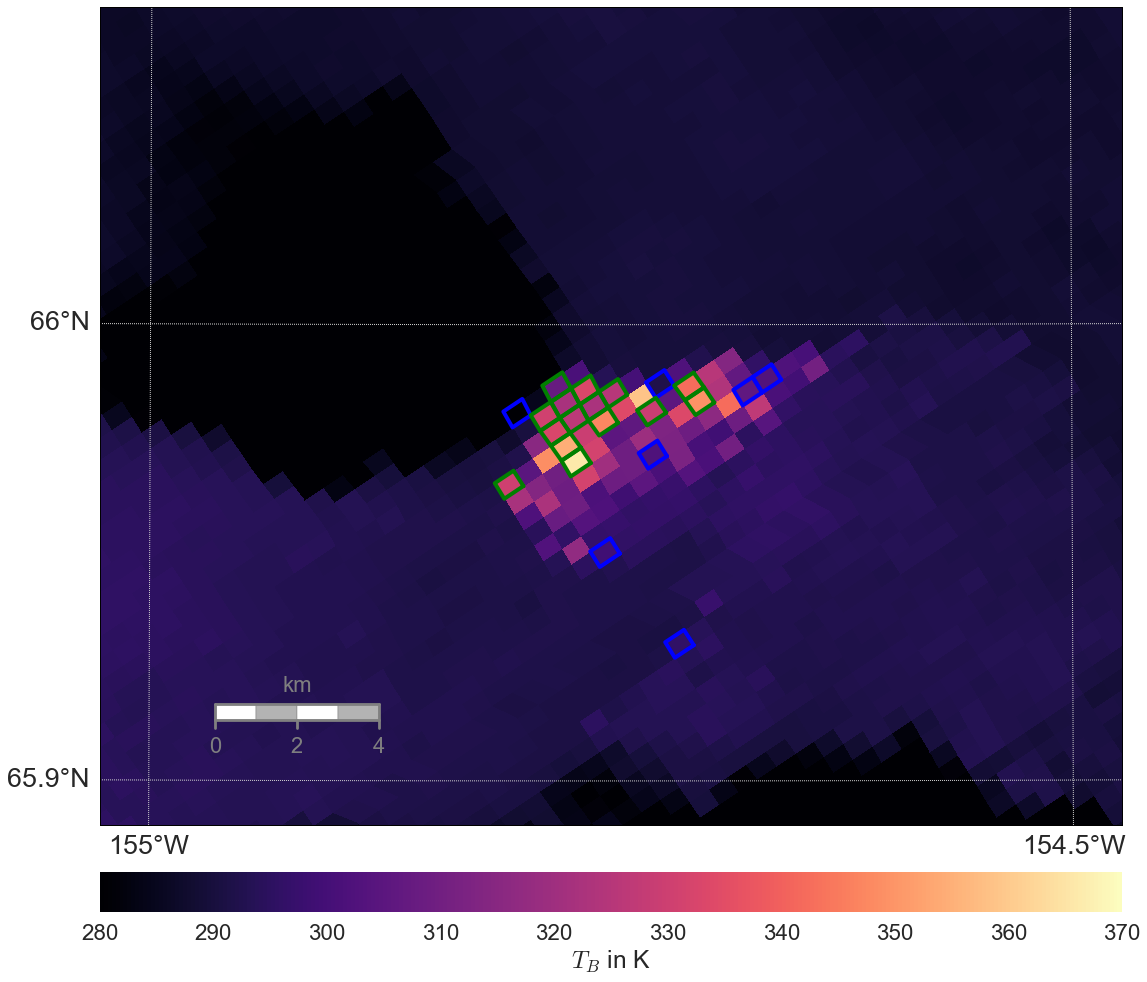

In [127]:
fig1 = plt.figure(1, figsize=(15, 15))
ax1 = fig1.add_subplot(111)
mm = Basemap(
    width=25000, height=20000, 
    resolution='i', 
    projection='aea', 
    lat_1=60., lat_2=70., lat_0=65.98, lon_0=sample_lon)
mm.drawrivers(color=water, linewidth=1.5);
mm.drawmeridians(
    np.arange(-180, 180, .5), 
    color='lightgrey',
    linewidth=1,
    labels=[False, False, False, True]);
mm.drawparallels(
    np.arange(0, 80, .1), 
    linewidth=1,
    color='lightgrey',
    labels=[True, False, False, False]);
mm.fillcontinents(        
    color=earth,
    lake_color=water)
mm.drawmapboundary(fill_color=water);
xx, yy = mm(lons, lats)
dataplt = mm.pcolormesh(xx, yy, plotraster5, edgecolors='None',  vmin=250, vmax=350, zorder=2)

iis, jjs =  np.where(pixq4 == 9)
for ii, jj in zip(iis, jjs):
    boxlons = [lons[ii, jj], lons[ii, jj+1], lons[ii+1, jj+1], lons[ii+1, jj], lons[ii, jj]]
    boxlats = [lats[ii, jj], lats[ii, jj+1], lats[ii+1, jj+1], lats[ii+1, jj], lats[ii, jj]]
    x, y = mm(boxlons, boxlats)
    ax1.plot(x, y, color='blue', linewidth=4, zorder=5)
iis, jjs =  np.where(pixq4 == 193)
for ii, jj in zip(iis, jjs):
    boxlons = [lons[ii, jj], lons[ii, jj+1], lons[ii+1, jj+1], lons[ii+1, jj], lons[ii, jj]]
    boxlats = [lats[ii, jj], lats[ii, jj+1], lats[ii+1, jj+1], lats[ii+1, jj], lats[ii, jj]]
    x, y = mm(boxlons, boxlats)
    ax1.plot(x, y, color='green', linewidth=4, zorder=5)
mm.drawmapscale(-154.92, 65.915, -154.7, 66.1, 4, 
                    barstyle="fancy", fontsize=22, zorder=6,
                    fontcolor='0.5', fillcolor2='0.7');

plt.tight_layout()
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size='5%', pad=0.65)
cbar = plt.colorbar(dataplt, orientation='horizontal', cax=cax)
cbar.set_label("$T_B$ in K")


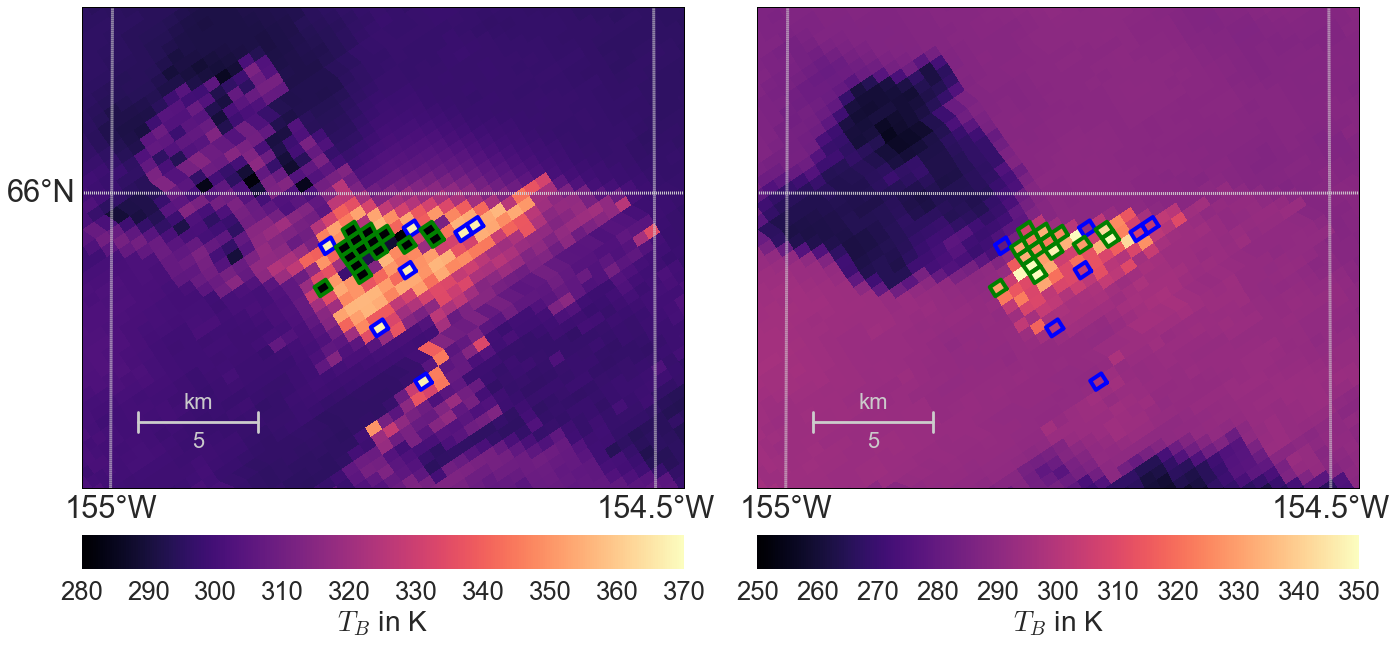

In [164]:
sns.set_context("poster", font_scale=1.6)

fig1, (ax0, ax1) = plt.subplots(
    ncols=2, figsize=(20, 9.5))
dataplots = []

tmin = [280, 250]
tmax = [370, 350]
plotrasters = [plotraster4, plotraster5]

#stuff common to both:

for ix, ax in enumerate([ax0, ax1]):
    mm = Basemap(
        width=25000, height=20000, 
        resolution='i', 
        projection='aea', 
        ax=ax,
        lat_1=60., lat_2=70., lat_0=65.98, lon_0=sample_lon)
    mm.drawrivers(color=water, linewidth=1.5);
    mm.drawmeridians(
        np.arange(-180, 180, .5), 
        color='lightgrey',
        linewidth=3,
        labels=[False, False, False, True]);
    mm.drawparallels(
        np.arange(0, 80, .2), 
        linewidth=3,
        color='lightgrey',
        labels=[True if ix==0 else False, False, False, False]);
    mm.fillcontinents(        
        color=earth,
        lake_color=water)
    mm.drawmapboundary(fill_color=water);
    mm.drawmapscale(-154.92, 65.915, -154.7, 66.1, 5, 
                    barstyle="simple", fontsize=22, zorder=6,
                    fontcolor='0.8', fillcolor2='0.3');
    xx, yy = mm(lons, lats)
    dataplt = mm.pcolormesh(xx, yy, plotrasters[ix], edgecolors='None', vmin=tmin[ix], vmax=tmax[ix], zorder=2)
    dataplots.append(dataplt)

    iis, jjs =  np.where(pixq4 == 9)
    for ii, jj in zip(iis, jjs):
        boxlons = [lons[ii, jj], lons[ii, jj+1], lons[ii+1, jj+1], lons[ii+1, jj], lons[ii, jj]]
        boxlats = [lats[ii, jj], lats[ii, jj+1], lats[ii+1, jj+1], lats[ii+1, jj], lats[ii, jj]]
        x, y = mm(boxlons, boxlats)
        ax.plot(x, y, color='blue', linewidth=4, zorder=5)
    iis, jjs =  np.where(pixq4 == 193)
    for ii, jj in zip(iis, jjs):
        boxlons = [lons[ii, jj], lons[ii, jj+1], lons[ii+1, jj+1], lons[ii+1, jj], lons[ii, jj]]
        boxlats = [lats[ii, jj], lats[ii, jj+1], lats[ii+1, jj+1], lats[ii+1, jj], lats[ii, jj]]
        x, y = mm(boxlons, boxlats)
        ax.plot(x, y, color='green', linewidth=4, zorder=5)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size='7%', pad=0.65)
    cbar = plt.colorbar(dataplt, orientation='horizontal', cax=cax)
    cbar.set_label("$T_B$ in K")
plt.tight_layout()
plt.subplots_adjust(left=0.075)

In [168]:
fn = 'Fig04.png'
fig1.savefig(os.path.join(outdir, fn), bb_inches='tight', dpi=400)

In [169]:
fn = 'Fig04_LR.png'
fig1.savefig(os.path.join(outdir, fn), bb_inches='tight', dpi=150 )

## Exploration of pixq4 values on raster only

In [176]:
from collections import Counter

In [146]:
sample_lat, sample_lon = 66.0, -154.75
imin, imax, jmin, jmax = testscene04.crop(sample_lat, sample_lon, 50, 30)

In [167]:
skips = vst.get_skips(testscene04, imin, imax, jmin, jmax)
skiprows = vst.get_badrows(skips)

In [179]:
Counter(pixq4.ravel())

Counter({0: 33130, 9: 15, 193: 20})

In [180]:
Counter(pixq5.ravel())

Counter({0: 33162, 65: 3})